In [90]:
!git clone https://github.com/kevinmbeaulieu/self-driving-car-track.git

fatal: destination path 'self-driving-car-track' already exists and is not an empty directory.


In [91]:
!ls self-driving-car-track/

driving_log.csv  IMG


In [0]:
import cv2
import keras
from keras.layers import Convolution2D, MaxPool2D, Dropout, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import ntpath
import numpy as np
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [93]:
datadir = 'self-driving-car-track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/center_2020_01_13_19_22_12_499.jpg,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/left_2020_01_13_19_22_12_499.jpg,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/right_2020_01_13_19_22_12_499.jpg,0.0,0.0,0,0.000078
1,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/center_2020_01_13_19_22_12_620.jpg,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/left_2020_01_13_19_22_12_620.jpg,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/right_2020_01_13_19_22_12_620.jpg,0.0,0.0,0,0.000080
2,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/center_2020_01_13_19_22_12_752.jpg,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/left_2020_01_13_19_22_12_752.jpg,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/right_2020_01_13_19_22_12_752.jpg,0.0,0.0,0,0.000081
3,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/center_2020_01_13_19_22_12_867.jpg,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/left_2020_01_13_19_22_12_867.jpg,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/right_2020_01_13_19_22_12_867.jpg,0.0,0.0,0,0.000078
4,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/center_2020_01_13_19_22_12_999.jpg,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/left_2020_01_13_19_22_12_999.jpg,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/right_2020_01_13_19_22_12_999.jpg,0.0,0.0,0,0.000079


In [0]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

In [95]:
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_01_13_19_22_12_499.jpg,left_2020_01_13_19_22_12_499.jpg,right_2020_01_13_19_22_12_499.jpg,0.0,0.0,0,0.000078
1,center_2020_01_13_19_22_12_620.jpg,left_2020_01_13_19_22_12_620.jpg,right_2020_01_13_19_22_12_620.jpg,0.0,0.0,0,0.000080
2,center_2020_01_13_19_22_12_752.jpg,left_2020_01_13_19_22_12_752.jpg,right_2020_01_13_19_22_12_752.jpg,0.0,0.0,0,0.000081
3,center_2020_01_13_19_22_12_867.jpg,left_2020_01_13_19_22_12_867.jpg,right_2020_01_13_19_22_12_867.jpg,0.0,0.0,0,0.000078
4,center_2020_01_13_19_22_12_999.jpg,left_2020_01_13_19_22_12_999.jpg,right_2020_01_13_19_22_12_999.jpg,0.0,0.0,0,0.000079


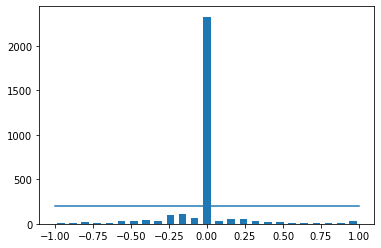

In [96]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 3060
removed: 2127
remaining: 933


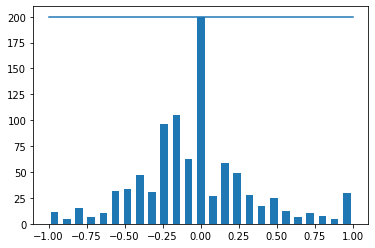

In [97]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, bins = np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [0]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

In [0]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [100]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('training samples: {}\nValid samples: {}'.format(len(X_train), len(X_valid)))

training samples: 746
Valid samples: 187


Text(0.5, 1.0, 'validation set')

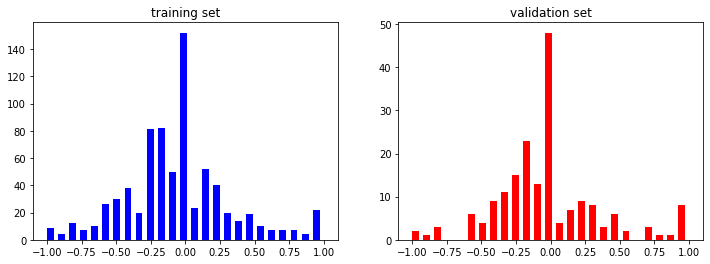

In [101]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('validation set')

In [0]:
def img_preprocess(img):
    img = mpimg.imread(img)
    img = img[60:135, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1, 'preprocessed image')

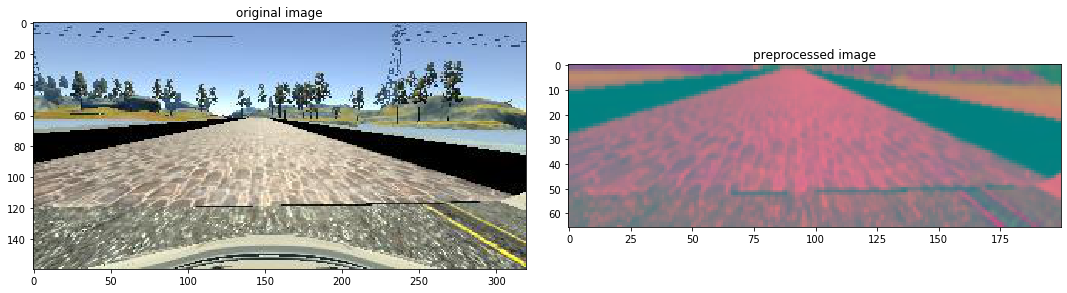

In [103]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('original image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('preprocessed image')

In [0]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(746, 66, 200, 3)


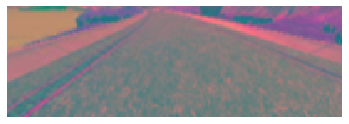

In [105]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [0]:
def nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Convolution2D(36, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Convolution2D(48, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    model.add(Dropout(rate=0.5))
    
    model.add(Flatten())
    
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(50, activation='elu'))
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(10, activation='elu'))
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(1))

    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    return model


In [121]:
model = nvidia_model()
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_11 (Dropout)         (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1152)             

In [122]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=True, shuffle=True)

Train on 746 samples, validate on 187 samples
Epoch 1/30
746/746 [==============================] - 6s 8ms/step - loss: 1.8289 - val_loss: 0.1830
Epoch 2/30
746/746 [==============================] - 5s 7ms/step - loss: 0.3760 - val_loss: 0.1480
Epoch 3/30
746/746 [==============================] - 5s 7ms/step - loss: 0.3123 - val_loss: 0.1306
Epoch 4/30
746/746 [==============================] - 5s 7ms/step - loss: 0.2326 - val_loss: 0.1206
Epoch 5/30
746/746 [==============================] - 5s 7ms/step - loss: 0.1943 - val_loss: 0.1204
Epoch 6/30
746/746 [==============================] - 5s 7ms/step - loss: 0.1576 - val_loss: 0.1202
Epoch 7/30
746/746 [==============================] - 5s 7ms/step - loss: 0.1670 - val_loss: 0.1181
Epoch 8/30
746/746 [==============================] - 5s 7ms/step - loss: 0.1627 - val_loss: 0.1134
Epoch 9/30
746/746 [==============================] - 5s 7ms/step - loss: 0.1560 - val_loss: 0.1027
Epoch 10/30
746/746 [==============================] -

Text(0.5, 0, 'epoch')

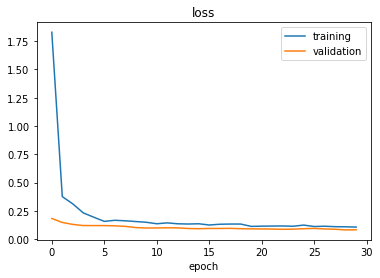

In [123]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files

files.download('model.h5')